In [ ]:
import subprocess
import sys
import os
from typing import Dict, List, Any, Optional, Union
import json
import asyncio
from datetime import datetime
import logging

def install_packages():
    """Install required packages for the tutorial"""
    packages = [
        'mcp',
        'google-generativeai',
        'requests',
        'beautifulsoup4',
        'matplotlib',
        'numpy',
        'websockets',
        'pydantic'
    ]

    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✅ Successfully installed {package}")
        except subprocess.CalledProcessError as e:
            print(f"❌ Failed to install {package}: {e}")

install_packages()

In [ ]:
import google.generativeai as genai
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np

from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
from mcp.types import TextContent, ImageContent, EmbeddedResource
import mcp.types as types

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
class MCPToolServer:
    """MCP Server that provides tools for the AI agent"""

    def __init__(self):
        self.tools = {
            "web_search": {
                "name": "web_search",
                "description": "Search the web for information",
                "inputSchema": {
                    "type": "object",
                    "properties": {
                        "query": {"type": "string", "description": "Search query"}
                    },
                    "required": ["query"]
                }
            },
            "data_analysis": {
                "name": "data_analysis",
                "description": "Analyze data and create visualizations",
                "inputSchema": {
                    "type": "object",
                    "properties": {
                        "data_type": {"type": "string", "description": "Type of analysis"},
                        "parameters": {"type": "object", "description": "Analysis parameters"}
                    },
                    "required": ["data_type"]
                }
            },
            "code_execution": {
                "name": "code_execution",
                "description": "Execute or generate code",
                "inputSchema": {
                    "type": "object",
                    "properties": {
                        "language": {"type": "string", "description": "Programming language"},
                        "task": {"type": "string", "description": "Code task description"}
                    },
                    "required": ["language", "task"]
                }
            },
            "weather_info": {
                "name": "weather_info",
                "description": "Get weather information",
                "inputSchema": {
                    "type": "object",
                    "properties": {
                        "location": {"type": "string", "description": "Location for weather"}
                    },
                    "required": ["location"]
                }
            }
        }

    async def list_tools(self) -> List[types.Tool]:
        """Return list of available tools"""
        return [types.Tool(**tool) for tool in self.tools.values()]

    async def call_tool(self, name: str, arguments: Dict[str, Any]) -> List[types.TextContent]:
        """Execute a tool and return results"""
        if name == "web_search":
            return await self._web_search(arguments.get("query", ""))
        elif name == "data_analysis":
            return await self._data_analysis(arguments.get("data_type", ""), arguments.get("parameters", {}))
        elif name == "code_execution":
            return await self._code_execution(arguments.get("language", ""), arguments.get("task", ""))
        elif name == "weather_info":
            return await self._weather_info(arguments.get("location", ""))
        else:
            return [types.TextContent(type="text", text=f"Unknown tool: {name}")]

    async def _web_search(self, query: str) -> List[types.TextContent]:
        """Perform web search"""
        try:
            search_url = f"https://www.wikipedia.org/wiki/Special:Search?search={query.replace(' ', '%20')}"
            headers = {'User-Agent': 'Mozilla/5.0 (compatible; MCP Agent)'}

            response = requests.get(search_url, headers=headers, timeout=10)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                paragraphs = soup.find_all('p')[:3]
                content = "\n".join([p.get_text().strip() for p in paragraphs if p.get_text().strip()])

                result = f"🔍 Web search results for '{query}':\n\n{content[:500]}..."
            else:
                result = f"❌ Web search failed with status: {response.status_code}"

        except Exception as e:
            result = f"❌ Web search error: {str(e)}"

        return [types.TextContent(type="text", text=result)]

    async def _data_analysis(self, data_type: str, parameters: Dict) -> List[types.TextContent]:
        """Perform data analysis"""
        try:
            if "sine" in data_type.lower() or "wave" in data_type.lower():
                x = np.linspace(0, 4*np.pi, 100)
                y = np.sin(x) + np.random.normal(0, 0.1, 100)
                title = "Sine Wave Analysis"
            else:
                x = np.random.normal(0, 1, 100)
                y = np.random.normal(0, 1, 100)
                title = "Random Data Analysis"

            plt.figure(figsize=(10, 6))
            plt.scatter(x, y, alpha=0.6)
            plt.title(f"📊 {title}")
            plt.xlabel("X Values")
            plt.ylabel("Y Values")
            plt.grid(True, alpha=0.3)
            plt.show()

            stats = {
                "mean_x": np.mean(x),
                "mean_y": np.mean(y),
                "std_x": np.std(x),
                "std_y": np.std(y),
                "correlation": np.corrcoef(x, y)[0,1]
            }

            result = f"📊 Data Analysis Results:\n"
            result += f"Dataset: {title}\n"
            result += f"Sample size: {len(x)}\n"
            result += f"X - Mean: {stats['mean_x']:.3f}, Std: {stats['std_x']:.3f}\n"
            result += f"Y - Mean: {stats['mean_y']:.3f}, Std: {stats['std_y']:.3f}\n"
            result += f"Correlation: {stats['correlation']:.3f}\n"
            result += f"\n📈 Visualization displayed above!"

        except Exception as e:
            result = f"❌ Data analysis error: {str(e)}"

        return [types.TextContent(type="text", text=result)]

    async def _code_execution(self, language: str, task: str) -> List[types.TextContent]:
        """Handle code generation/execution"""
        try:
            if language.lower() == "python":
                if "fibonacci" in task.lower():
                    code = '''def fibonacci(n):
    """Generate fibonacci sequence up to n terms"""
    if n <= 0:
        return []
    elif n == 1:
        return [0]
    elif n == 2:
        return [0, 1]

    fib = [0, 1]
    for i in range(2, n):
        fib.append(fib[i-1] + fib[i-2])
    return fib

# Example usage
print("First 10 fibonacci numbers:", fibonacci(10))'''

                elif "sort" in task.lower():
                    code = '''def quicksort(arr):
    """Quick sort implementation"""
    if len(arr) <= 1:
        return arr
    pivot = arr[len(arr) // 2]
    left = [x for x in arr if x < pivot]
    middle = [x for x in arr if x == pivot]
    right = [x for x in arr if x > pivot]
    return quicksort(left) + middle + quicksort(right)

# Example usage
data = [64, 34, 25, 12, 22, 11, 90]
print("Original:", data)
print("Sorted:", quicksort(data))'''

                else:
                    code = f'''# Python code for: {task}
# This is a template - customize based on your specific needs

def main():
    """Main function for {task}"""
    print("Implementing: {task}")
    # Add your implementation here
    pass

if __name__ == "__main__":
    main()'''

                result = f"💻 Python Code for '{task}':\n\n```python\n{code}\n```"

                if "fibonacci" in task.lower():
                    try:
                        exec(code)
                        result += "\n\n✅ Code executed successfully!"
                    except Exception as exec_error:
                        result += f"\n\n⚠️ Execution note: {exec_error}"

            else:
                result = f"💻 Code template for {language}:\n\n"
                result += f"// {task}\n// Language: {language}\n// Add your implementation here"

        except Exception as e:
            result = f"❌ Code generation error: {str(e)}"

        return [types.TextContent(type="text", text=result)]

    async def _weather_info(self, location: str) -> List[types.TextContent]:
        """Get weather information"""
        weather_data = {
            "temperature": np.random.randint(15, 30),
            "condition": np.random.choice(["Sunny", "Cloudy", "Rainy", "Partly Cloudy"]),
            "humidity": np.random.randint(40, 80),
            "wind_speed": np.random.randint(5, 25)
        }

        result = f"🌤️ Weather for {location}:\n"
        result += f"Temperature: {weather_data['temperature']}°C\n"
        result += f"Condition: {weather_data['condition']}\n"
        result += f"Humidity: {weather_data['humidity']}%\n"
        result += f"Wind Speed: {weather_data['wind_speed']} km/h\n"
        result += f"\n📝 Note: This is simulated data. For real weather, use a weather API service."

        return [types.TextContent(type="text", text=result)]

In [ ]:
class MCPAgent:
    """AI Agent using MCP (Model Context Protocol)"""

    def __init__(self, gemini_api_key: Optional[str] = None):
        self.gemini_api_key = gemini_api_key or self._get_api_key()
        self.mcp_server = MCPToolServer()
        self.conversation_history = []

        if self.gemini_api_key:
            genai.configure(api_key=self.gemini_api_key)
            self.model = genai.GenerativeModel('gemini-1.5-flash')
            print("✅ MCP Agent initialized with Gemini!")
        else:
            self.model = None
            print("⚠️ MCP Agent initialized without Gemini (limited functionality)")

    def _get_api_key(self) -> Optional[str]:
        """Get Gemini API key"""
        api_key = os.environ.get('GEMINI_API_KEY')
        if not api_key:
            print("📝 Get your free API key from: https://makersuite.google.com/app/apikey")
            api_key = input("Enter your Gemini API key (or press Enter to skip): ").strip()
        return api_key if api_key else None

    async def process_request(self, user_input: str) -> str:
        """Process user request using MCP tools and Gemini"""
        self.conversation_history.append({"role": "user", "content": user_input})

        available_tools = await self.mcp_server.list_tools()
        tool_descriptions = "\n".join([f"- {tool.name}: {tool.description}" for tool in available_tools])

        if self.model:
            analysis_prompt = f"""
            User request: "{user_input}"

            Available MCP tools:
            {tool_descriptions}

            Should I use a tool for this request? If yes, specify:
            1. Tool name (exact match)
            2. Arguments as JSON

            If no tool needed, respond with "NO_TOOL".

            Format: TOOL_NAME|{{"argument": "value"}}
            """

            analysis = self.model.generate_content(analysis_prompt).text.strip()

            if analysis != "NO_TOOL" and "|" in analysis:
                try:
                    tool_name, args_json = analysis.split("|", 1)
                    tool_name = tool_name.strip()
                    arguments = json.loads(args_json)

                    tool_results = await self.mcp_server.call_tool(tool_name, arguments)
                    tool_output = "\n".join([content.text for content in tool_results])

                    final_prompt = f"""
                    User asked: "{user_input}"

                    I used the {tool_name} tool and got this result:
                    {tool_output}

                    Please provide a helpful response that incorporates this information.
                    """

                    response = self.model.generate_content(final_prompt).text

                except Exception as e:
                    response = f"❌ Error using MCP tool: {str(e)}\n\nLet me help you directly instead.\n"
                    response += self.model.generate_content(user_input).text
            else:
                response = self.model.generate_content(user_input).text
        else:
            response = f"🤖 MCP Agent received: {user_input}\n"
            response += "Available tools: " + ", ".join([tool.name for tool in available_tools])
            response += "\n💡 Configure Gemini API for full functionality!"

        self.conversation_history.append({"role": "assistant", "content": response})
        return response

🎯 Advanced AI Agent with MCP (Model Context Protocol)
Built for Google Colab with Gemini API integration
🚀 MCP Agent Demo Starting!
✅ MCP Agent initialized with Gemini!

🧪 Running MCP Tool Demonstrations:
----------------------------------------

📝 Query 1: Search for information about machine learning
------------------------------
Machine learning (ML) is a branch of artificial intelligence focused on creating algorithms that learn from data without explicit programming.  This means instead of being explicitly told how to perform a task, the algorithm identifies patterns and makes predictions based on the data it's trained on.  The search results highlight that these algorithms, often statistical in nature, aim to generalize their learning to new, unseen data.  Recent advancements in deep learning, a subfield of machine learning using neural networks, have significantly improved the performance of many ML approaches.  ML is used across a wide range of applications (the search results

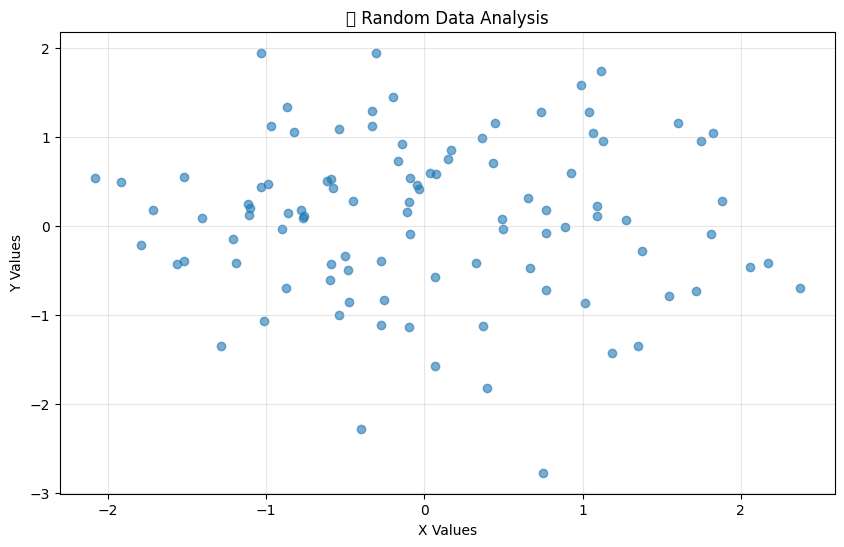

The data analysis shows a weak negative correlation (-0.038) between the X and Y variables in your dataset.  This suggests there's very little linear relationship between them.  The means and standard deviations provide a sense of the data's central tendency and spread.  However, the key takeaway is the near-zero correlation, indicating that a simple linear model wouldn't be effective in predicting Y based on X.

Since you mentioned "sine wave analysis," I'm assuming you suspect a cyclical or periodic pattern in your data. A weak linear correlation doesn't rule this out.  To better understand if a sine wave is a suitable model, we need more information:

* **The visualization itself:**  The `📈 Visualization displayed above!` is crucial.  Please provide the actual visualization (a chart or image).  This is essential to assess the presence of cyclical patterns.  Does the data appear to oscillate around a mean?  What's the approximate frequency of these oscillations?

* **The data itself:

In [7]:
async def run_mcp_demo():
    """Run comprehensive MCP Agent demo"""
    print("🚀 MCP Agent Demo Starting!")
    print("=" * 50)

    agent = MCPAgent()

    demo_queries = [
        "Search for information about machine learning",
        "Create a data visualization with sine wave analysis",
        "Write a Python function to calculate fibonacci numbers",
        "What's the weather like in New York?",
        "Explain how artificial intelligence works"
    ]

    print("\n🧪 Running MCP Tool Demonstrations:")
    print("-" * 40)

    for i, query in enumerate(demo_queries, 1):
        print(f"\n📝 Query {i}: {query}")
        print("-" * 30)

        response = await agent.process_request(query)
        print(response)

        if i < len(demo_queries):
            print("\n⏳ Next demo in 3 seconds...")
            await asyncio.sleep(3)

    print("\n✅ MCP Demo completed!")
    return agent

async def interactive_mcp_mode(agent: MCPAgent):
    """Interactive mode with MCP agent"""
    print("\n💬 Interactive MCP Mode!")
    print("Type 'quit' to exit, 'tools' to see available MCP tools")

    while True:
        try:
            user_input = input("\n🗣️ You: ").strip()

            if user_input.lower() == 'quit':
                print("👋 Goodbye!")
                break
            elif user_input.lower() == 'tools':
                tools = await agent.mcp_server.list_tools()
                print("\n🛠️ Available MCP Tools:")
                for tool in tools:
                    print(f"  - {tool.name}: {tool.description}")
                continue
            elif not user_input:
                continue

            response = await agent.process_request(user_input)
            print(f"\n🤖 MCP Agent: {response}")

        except KeyboardInterrupt:
            print("\n👋 Goodbye!")
            break
        except Exception as e:
            print(f"❌ Error: {str(e)}")


if __name__ == "__main__":
    print("🎯 Advanced AI Agent with MCP (Model Context Protocol)")
    print("Built for Google Colab with Gemini API integration")
    print("=" * 60)

    agent = asyncio.run(run_mcp_demo())

    asyncio.run(interactive_mcp_mode(agent))

    print("\n📚 MCP Tutorial Complete!")
    print("\n🔍 What you learned:")
    print("✅ How to implement MCP (Model Context Protocol) tools")
    print("✅ Tool registration and discovery")
    print("✅ Structured tool calling with arguments")
    print("✅ Integration between MCP tools and Gemini AI")
    print("✅ Async tool execution and response handling")